- eui-24e124710c408089 --> OpenLab - Laser room
- eui-24e124128c147444 --> Biblio filosofia y lletres
- eui-24e124128c147500 --> OpenLab - Main room
- eui-24e124128c147204 --> DigitalLab
- eui-24e124128c147499 --> AudioLab
- am307-9074 --> Computer room
- q4-1003-7456 --> Q4-1003
- eui-24e124128c147446
- eui-24e124128c147470

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
df = pd.read_csv('./Sensors_cleansed.csv')

# Pivot the data to have a column for each field (co2, temperature, humidity)
df_pivot = df.pivot_table(index='_time', columns='_field', values='_value').reset_index()

# Parse datetime
df['_time'] = pd.to_datetime(df['_time'], format='ISO8601')


# Sort by time
df_pivot = df_pivot.sort_values('_time')

# Filter by location (Example: am307-9074)
location = 'am307-9074'
df_location = df[df['location'] == location].pivot_table(index='_time', columns='_field', values='_value').reset_index()

# Fill missing values if necessary
df_location = df_location.fillna(method='ffill').fillna(method='bfill')

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_location[['co2', 'temperature', 'humidity']])

# Create training data
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], look_back, X.shape[2]))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [23]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 3)))
model.add(LSTM(50))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')

# history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

# Save the model
# model.save('lstm_model_Q4.h5')

In [24]:
# model = tf.keras.models.load_model('lstm_model.h5')

In [25]:
model.load_weights('lstm_model.h5')

In [26]:
import matplotlib.pyplot as plt

605/605 [==============================] - 2s 4ms/step


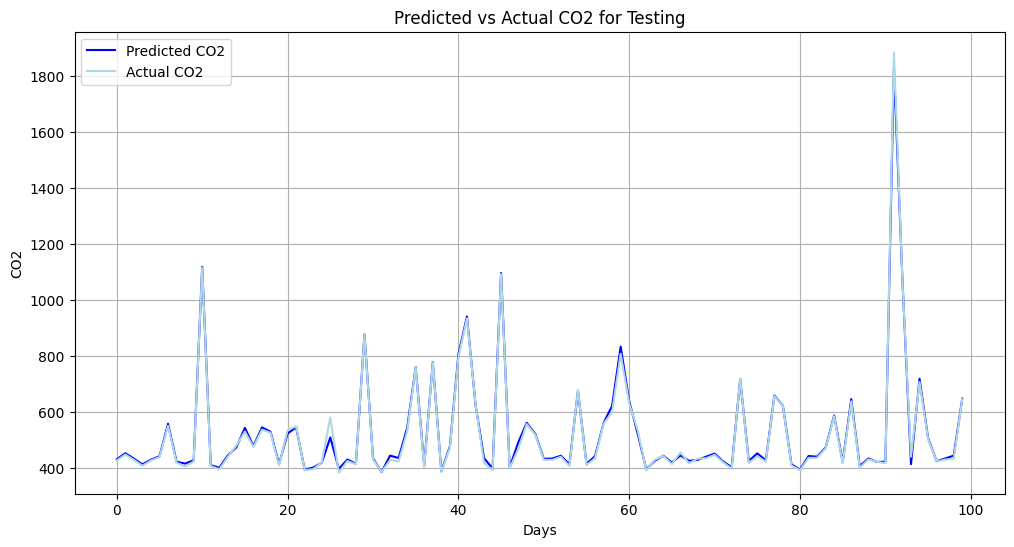

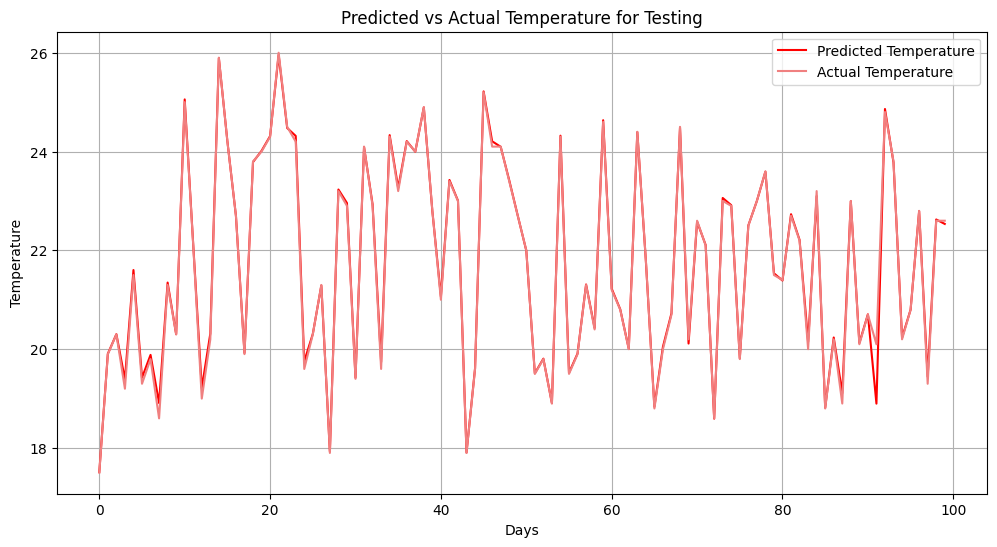

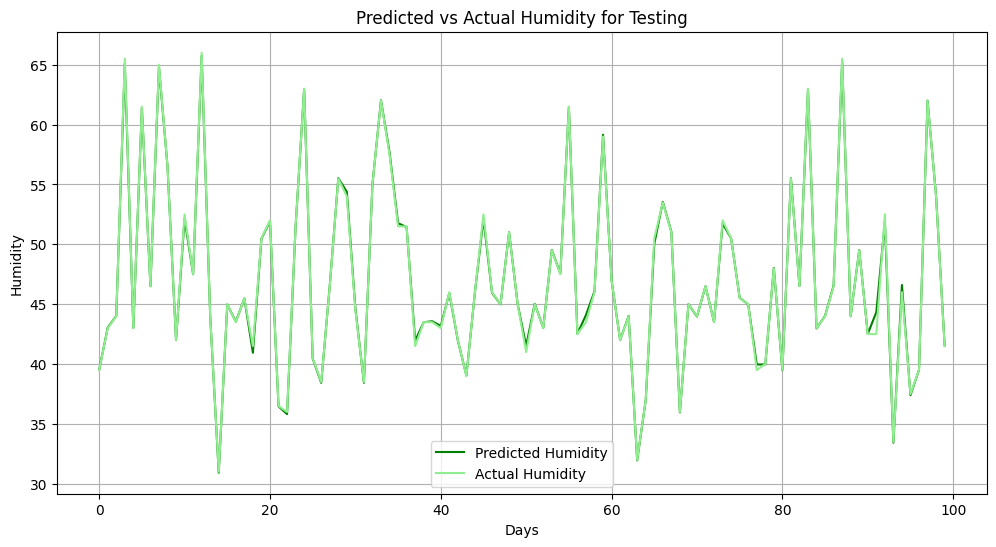

In [27]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform(Y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform(Y_test)

# Predict for the test set
Y_test_pred = model.predict(X_test)
Y_test_pred_inv = scaler.inverse_transform(Y_test_pred)

import random

def plot_predictions_sample(predictions, actual, title, sample_size=100):
    # Seleccionar una muestra aleatoria de los datos
    indices = random.sample(range(len(predictions)), min(sample_size, len(predictions)))
    sampled_predictions = predictions[indices]
    sampled_actual = actual[indices]

    # Gráficos
    plt.figure(figsize=(12, 6))
    days = np.arange(len(sampled_predictions))
    plt.plot(days, sampled_predictions[:, 0], color='blue', label='Predicted CO2')
    plt.plot(days, sampled_actual[:, 0], color='lightblue', label='Actual CO2')
    plt.title(f'Predicted vs Actual CO2 for {title}')
    plt.xlabel('Days')
    plt.ylabel('CO2')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(days, sampled_predictions[:, 1], color='red', label='Predicted Temperature')
    plt.plot(days, sampled_actual[:, 1], color='lightcoral', label='Actual Temperature')
    plt.title(f'Predicted vs Actual Temperature for {title}')
    plt.xlabel('Days')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(days, sampled_predictions[:, 2], color='green', label='Predicted Humidity')
    plt.plot(days, sampled_actual[:, 2], color='lightgreen', label='Actual Humidity')
    plt.title(f'Predicted vs Actual Humidity for {title}')
    plt.xlabel('Days')
    plt.ylabel('Humidity')
    plt.legend()
    plt.grid(True)
    plt.show()


# plot_predictions_sample(train_predict, Y_train_inv, 'Training')
plot_predictions_sample(test_predict, Y_test_inv, 'Testing')

In [31]:
# Load the trained model
model = tf.keras.models.load_model('lstm_model.h5')

# Define the function to make predictions for the next months
def predict_future(scaled_data, model, months=1):
    look_back = 10
    predictions = []

    # Start predicting from the last available data point
    input_data = scaled_data[-look_back:]
    input_data = np.reshape(input_data, (1, look_back, 3))

    # Predict for each month
    for month in range(months):
        month_predictions = []
        for day in range(30):  # Predict for 30 days in each month
            next_pred = model.predict(input_data)
            month_predictions.append(next_pred[0])
            input_data = np.append(input_data[:, 1:, :], [next_pred], axis=1)

        # Inverse transform predictions
        month_predictions = scaler.inverse_transform(month_predictions)
        predictions.append(month_predictions)

    return predictions

# Predict the next month
future_predictions = predict_future(scaled_data, model, months=1)

# Calculate and print the mean values for each month
month_names = ['February']
for i, month_predictions in enumerate(future_predictions):
    month_mean = np.mean(month_predictions, axis=0)
    print(f"Predicted mean values for {month_names[i]} next year in room {location}:")
    print(f"CO2: {month_mean[0]:.2f}, Temperature: {month_mean[1]:.2f}, Humidity: {month_mean[2]:.2f}")

1/1 [==============================] - 0s 24ms/step
Predicted mean values for February next year in room am307-9074:
CO2: 599.56, Temperature: 24.81, Humidity: 52.03


In [36]:
def predict_future(scaled_data, model, months=1):
    look_back = 10
    predictions = []

    # Start predicting from the last available data point
    input_data = scaled_data[-look_back:]
    print(input_data)
    input_data = np.reshape(input_data, (1, look_back, 3))

    # Predict for each month
    for month in range(months):
        month_predictions = []
        for day in range(30):  # Predict for 30 days in each month
            next_pred = model.predict(input_data)
            month_predictions.append(next_pred[0])
            input_data = np.append(input_data[:, 1:, :], [next_pred], axis=1)

        # Inverse transform predictions
        month_predictions = scaler.inverse_transform(month_predictions)
        predictions.append(month_predictions)

    return np.array(predictions)

# Predict the next month
future_predictions = predict_future(scaled_data, model, months=1)

# Print predictions for each day in February
for day, prediction in enumerate(future_predictions[0]):
    print(f"Prediction for February {day+1}: CO2: {prediction[0]:.2f}, Temperature: {prediction[1]:.2f}, Humidity: {prediction[2]:.2f}")


[[0.02758092 0.45971564 0.64130435]
 [0.03141161 0.45971564 0.64130435]
 [0.03141161 0.45971564 0.65217391]
 [0.03141161 0.4549763  0.65217391]
 [0.03428462 0.4549763  0.65217391]
 [0.03428462 0.4549763  0.66304348]
 [0.03428462 0.4549763  0.66304348]
 [0.03658303 0.4549763  0.66304348]
 [0.03658303 0.4549763  0.66304348]
 [0.03658303 0.4549763  0.66304348]]
1/1 [==============================] - 0s 19ms/step
Prediction for February 1: CO2: 549.54, Temperature: 24.32, Humidity: 52.51
Prediction for February 2: CO2: 553.24, Temperature: 24.34, Humidity: 52.56
Prediction for February 3: CO2: 557.95, Temperature: 24.36, Humidity: 52.54
Prediction for February 4: CO2: 561.99, Temperature: 24.39, Humidity: 52.50
Prediction for February 5: CO2: 565.68, Temperature: 24.42, Humidity: 52.47
Prediction for February 6: CO2: 569.20, Temperature: 24.46, Humidity: 52.43
Prediction for February 7: CO2: 572.50, Temperature: 24.49, Humidity: 52.41
Prediction for February 8: CO2: 575.89, Temperature: 24

In [35]:
# import matplotlib.pyplot as plt

# # Get predictions for February
# february_predictions = future_predictions[0]

# # Extract CO2, temperature, and humidity predictions
# co2_predictions = february_predictions[:, 0]
# temperature_predictions = february_predictions[:, 1]
# humidity_predictions = february_predictions[:, 2]

# # Plot predictions for CO2
# plt.figure(figsize=(10, 6))
# plt.bar(range(1, len(co2_predictions) + 1), co2_predictions, color='blue')
# plt.xlabel('Day in February')
# plt.ylabel('CO2 Prediction')
# plt.title('CO2 Predictions for February')
# plt.grid(True)
# plt.show()

# # Plot predictions for temperature
# plt.figure(figsize=(10, 6))
# plt.bar(range(1, len(temperature_predictions) + 1), temperature_predictions, color='orange')
# plt.xlabel('Day in February')
# plt.ylabel('Temperature Prediction')
# plt.title('Temperature Predictions for February')
# plt.grid(True)
# plt.show()

# # Plot predictions for humidity
# plt.figure(figsize=(10, 6))
# plt.bar(range(1, len(humidity_predictions) + 1), humidity_predictions, color='green')
# plt.xlabel('Day in February')
# plt.ylabel('Humidity Prediction')
# plt.title('Humidity Predictions for February')
# plt.grid(True)
# plt.show()


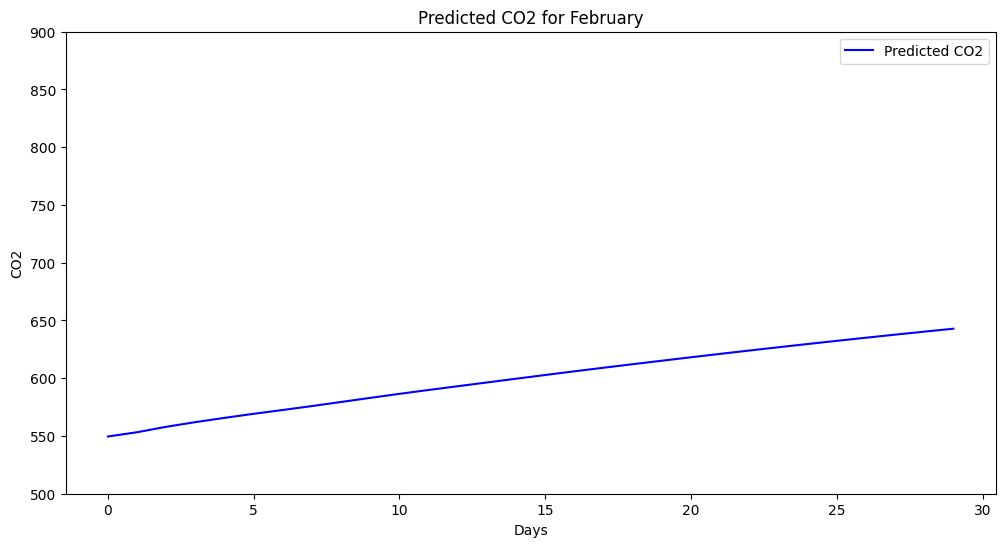

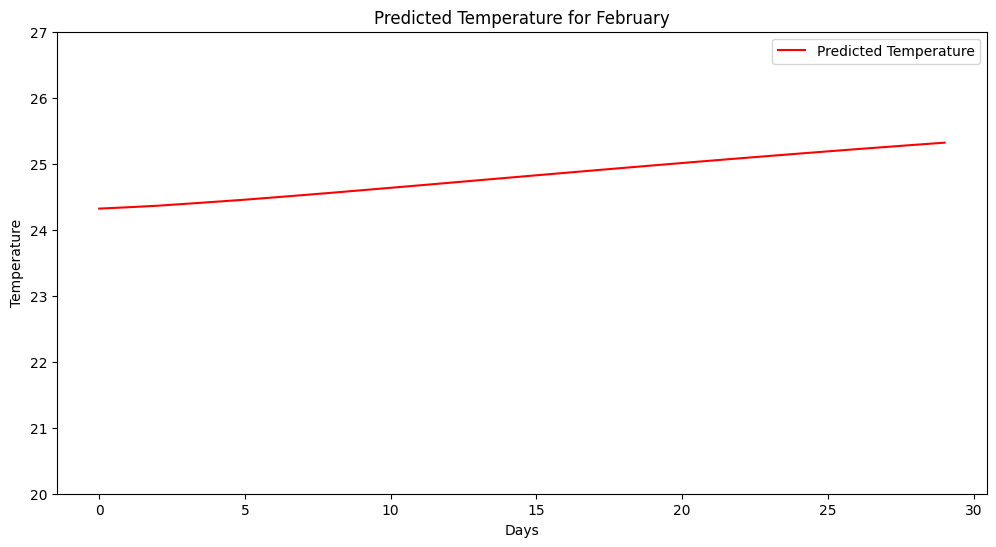

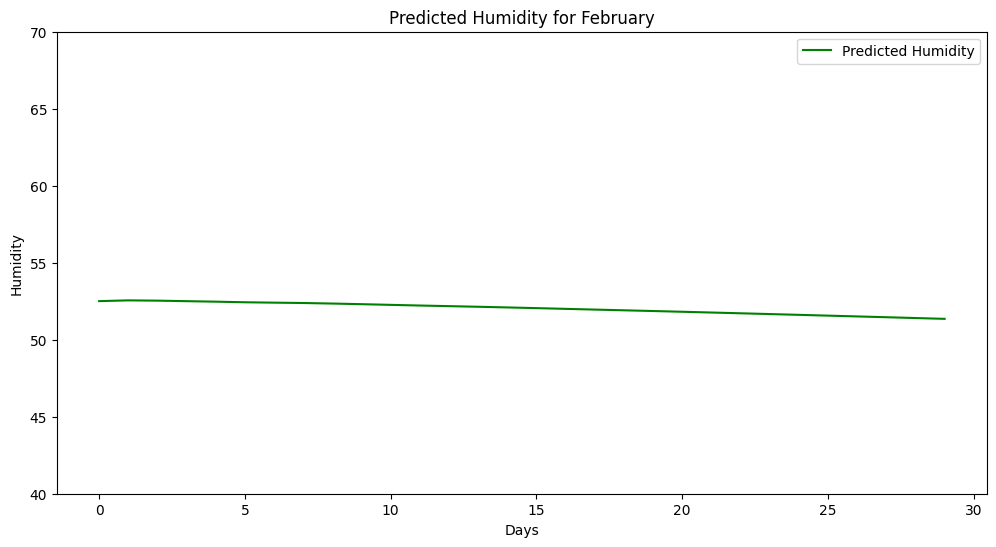

In [30]:
for i, month_predictions in enumerate(future_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(month_predictions[:, 0], label='Predicted CO2', color='blue')
    plt.ylim(500, 900)
    plt.title(f'Predicted CO2 for {month_names[i]}')
    plt.xlabel('Days')
    plt.ylabel('CO2')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(month_predictions[:, 1], label='Predicted Temperature', color='red')
    plt.ylim(20, 27)
    plt.title(f'Predicted Temperature for {month_names[i]}')
    plt.xlabel('Days')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(month_predictions[:, 2], label='Predicted Humidity', color='green')
    plt.ylim(40, 70)
    plt.title(f'Predicted Humidity for {month_names[i]}')
    plt.xlabel('Days')
    plt.ylabel('Humidity')
    plt.legend()
    plt.show()


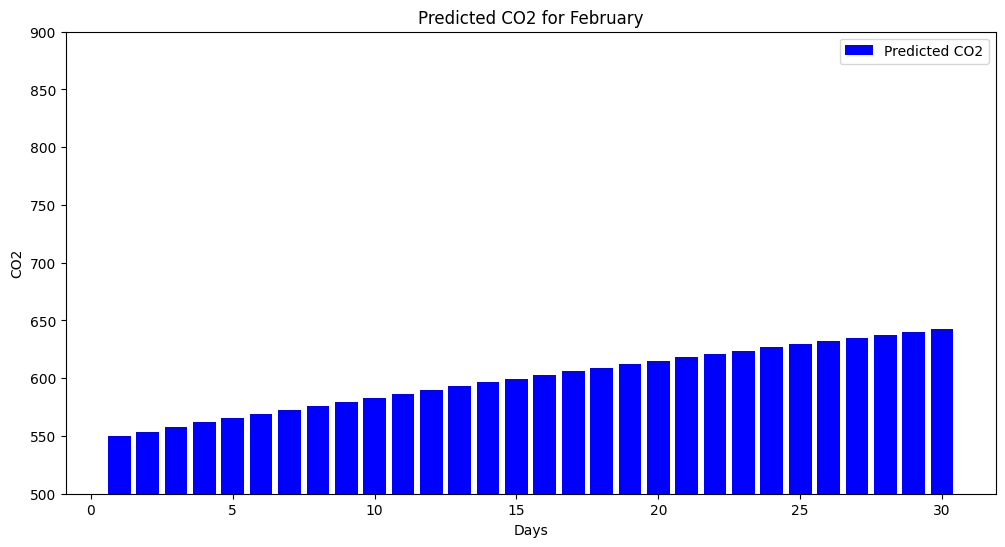

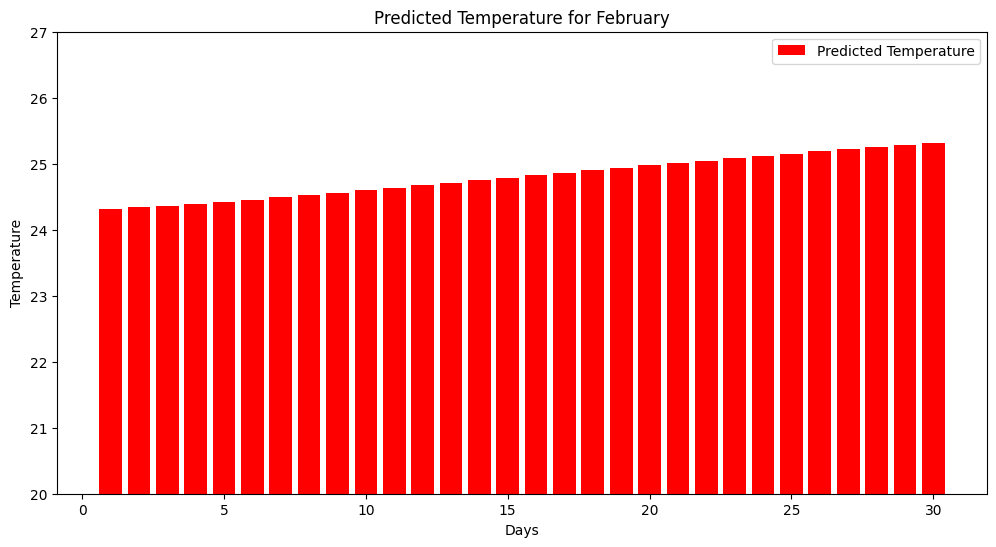

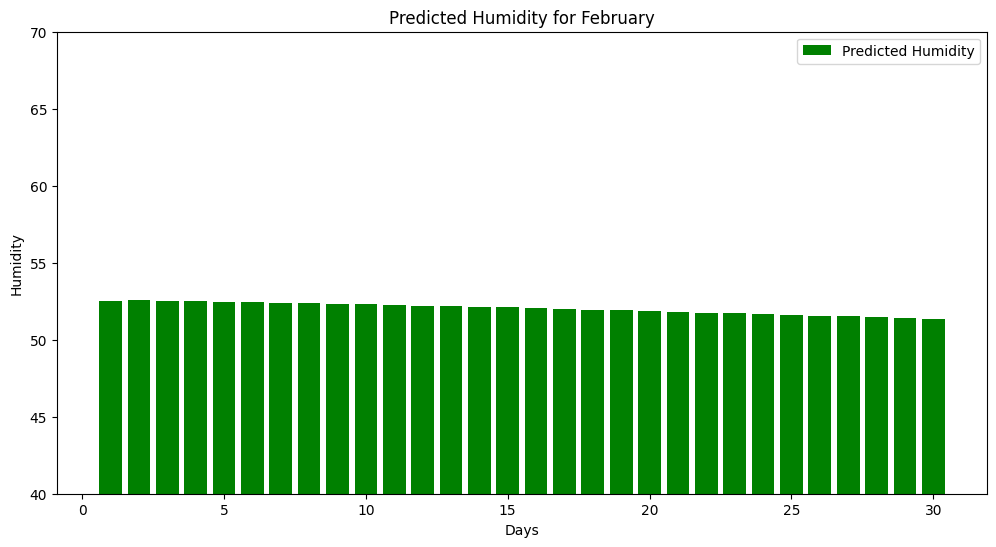

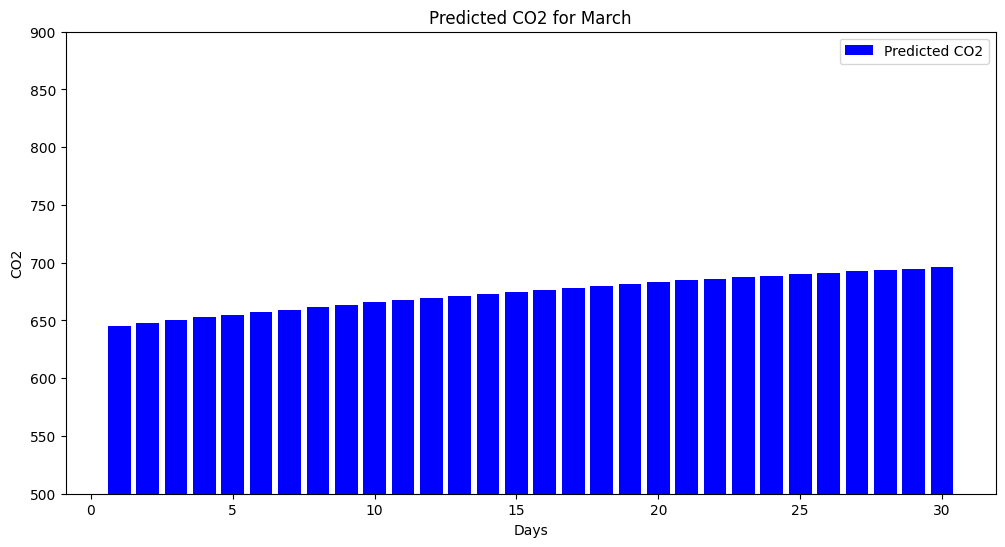

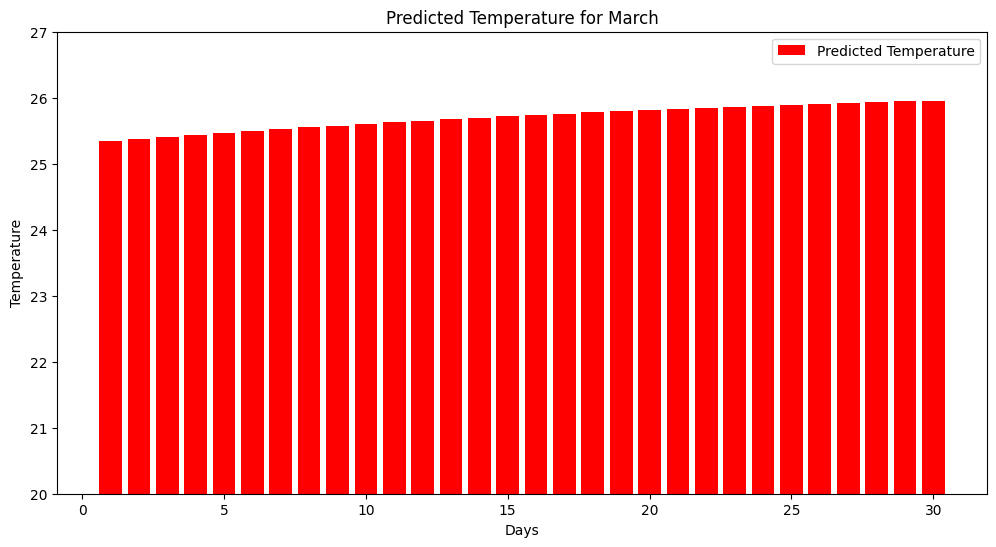

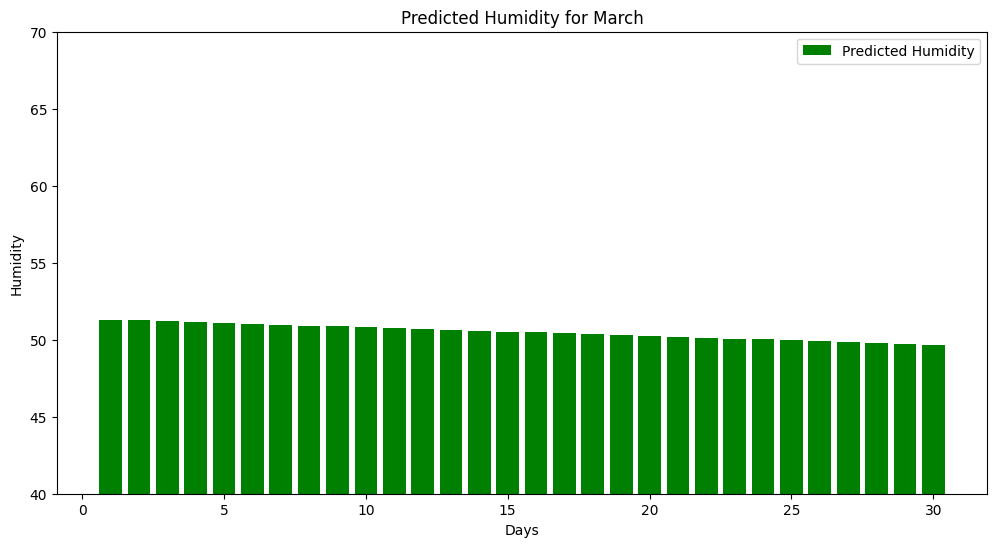

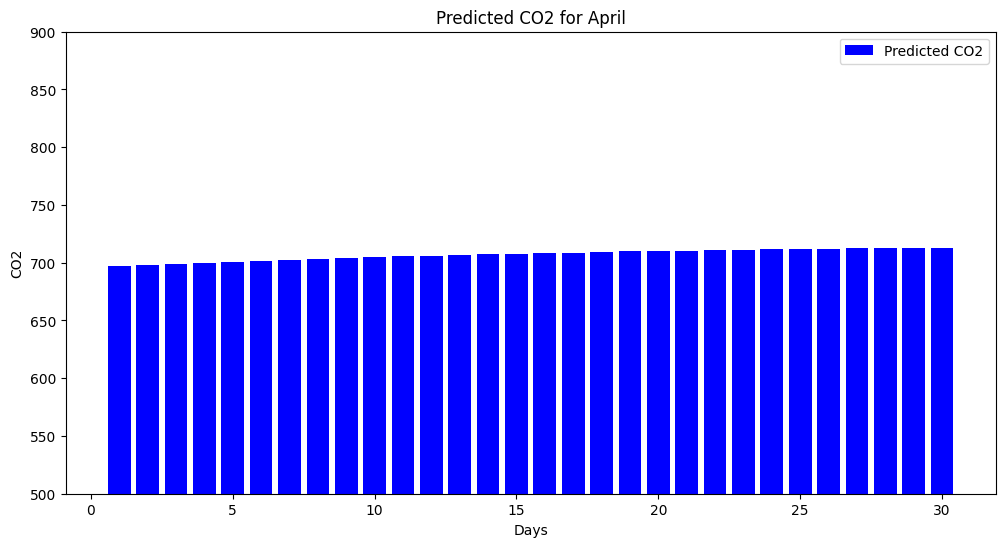

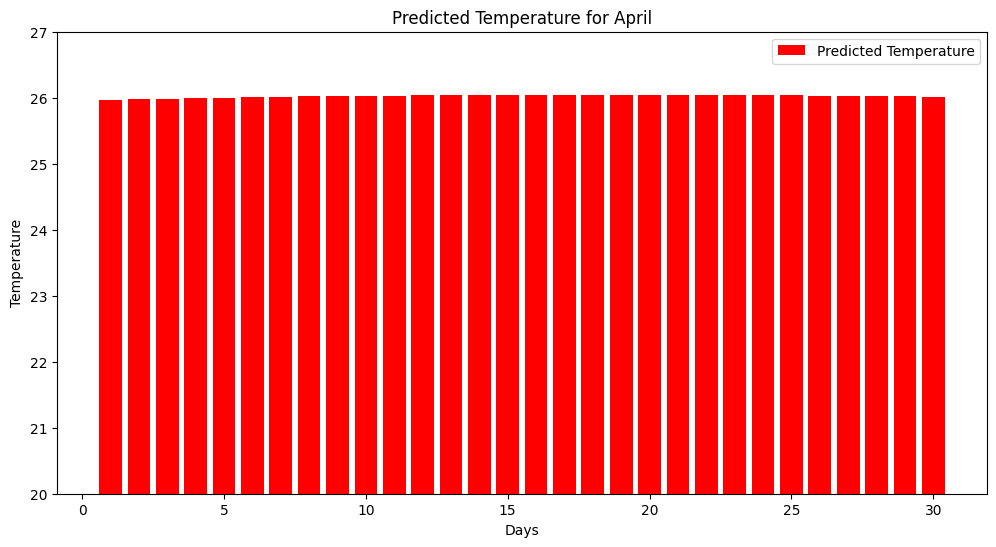

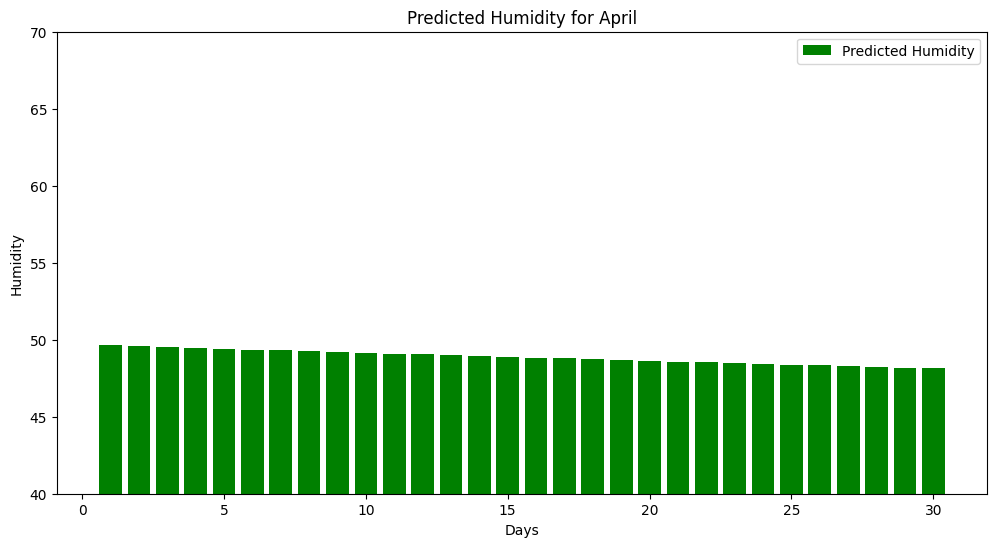

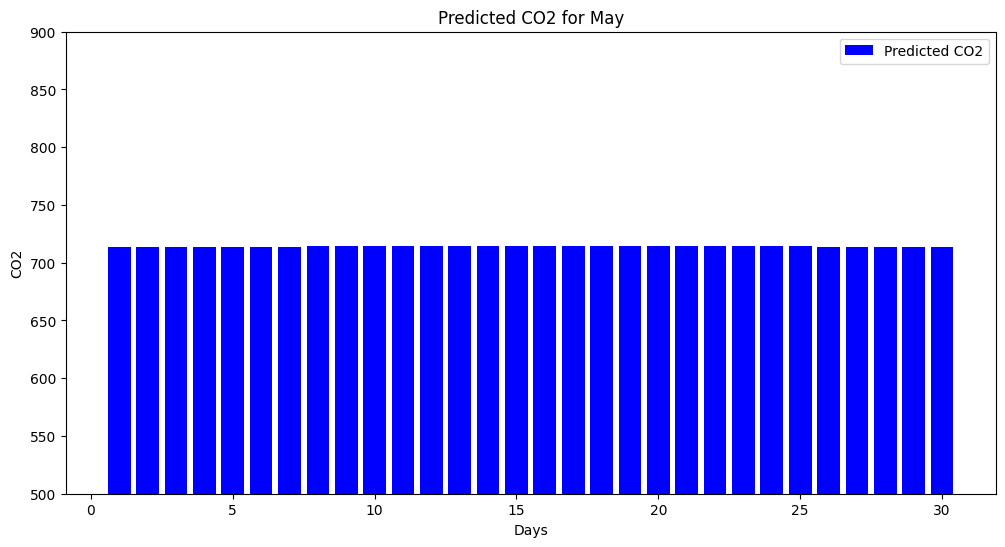

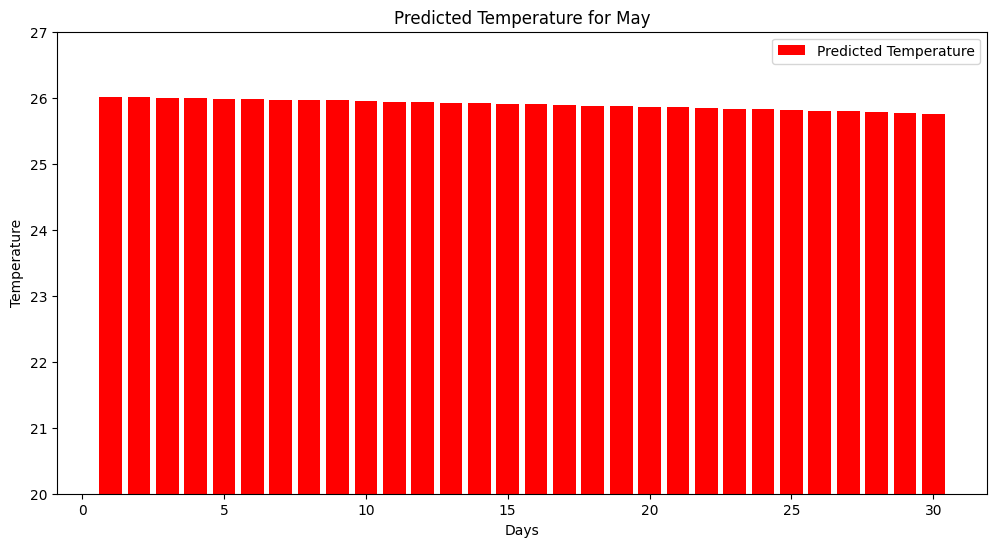

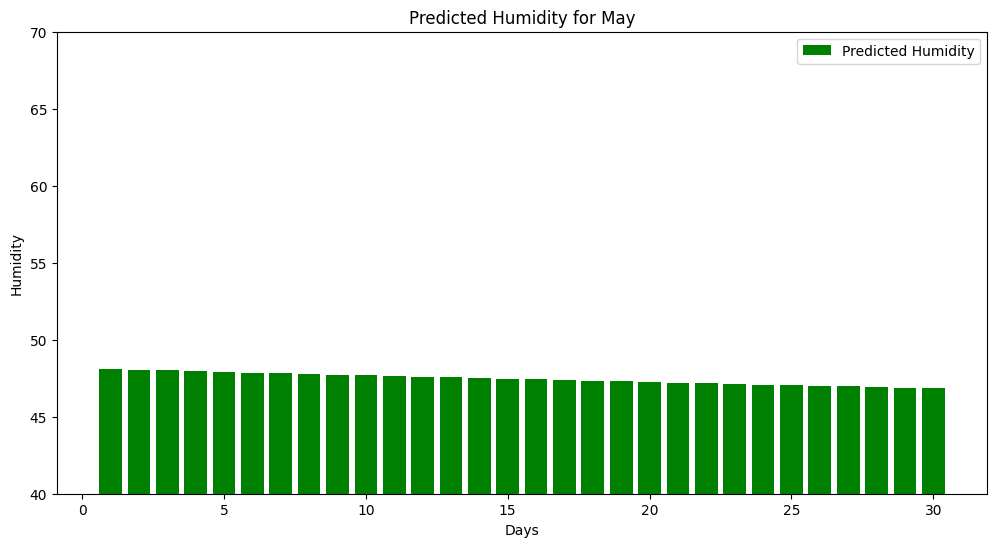

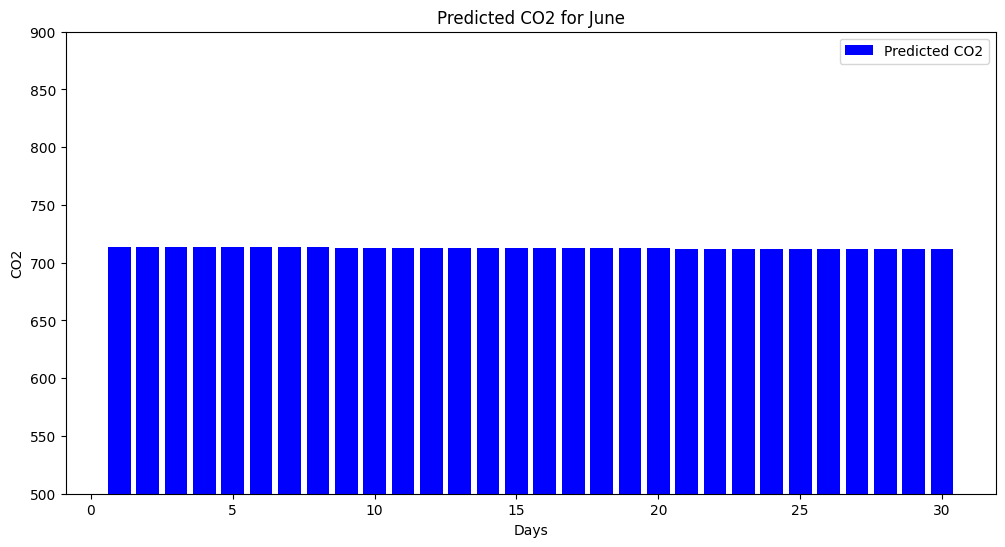

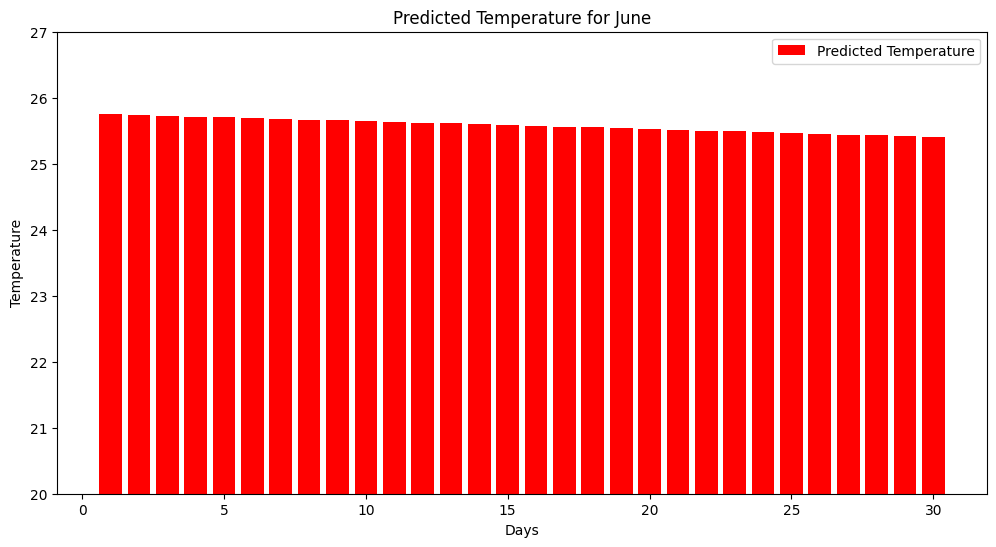

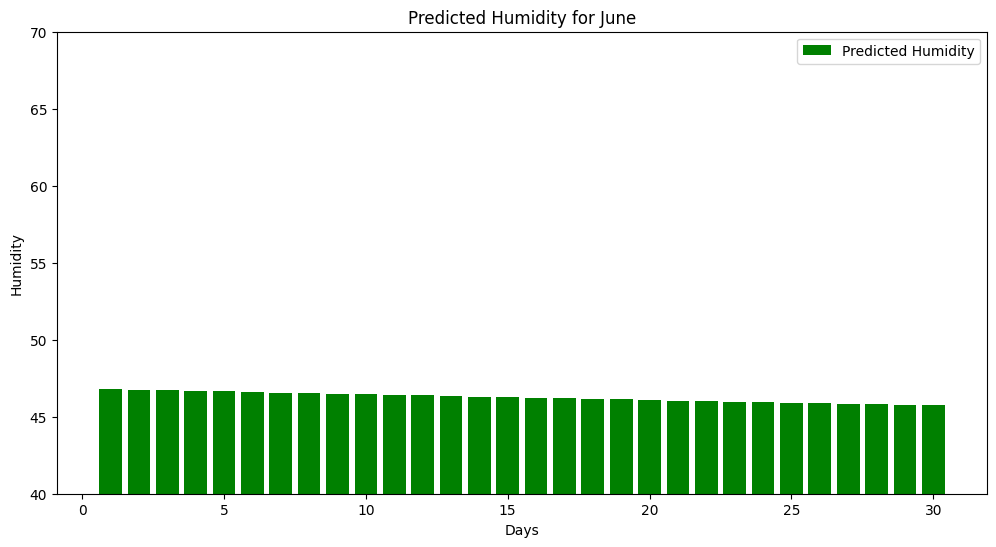

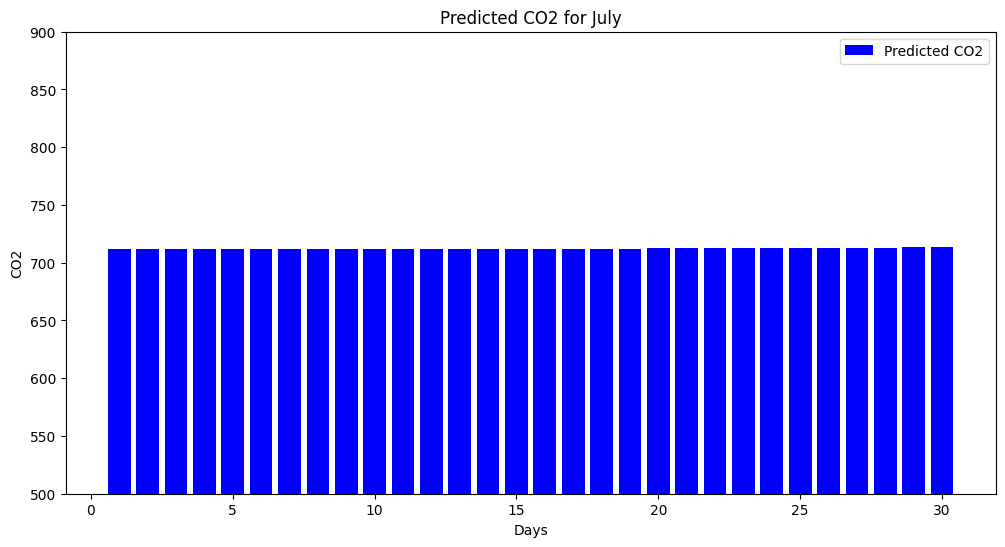

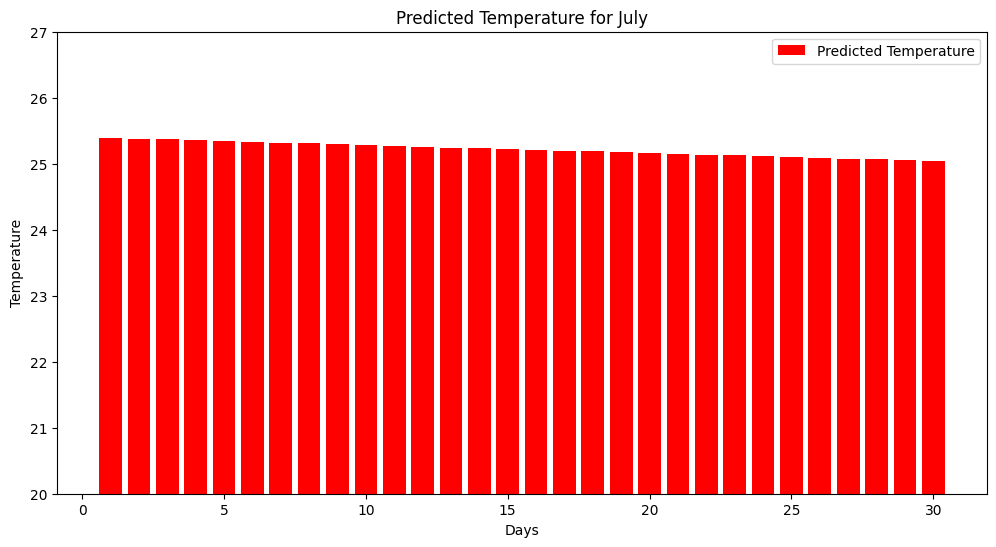

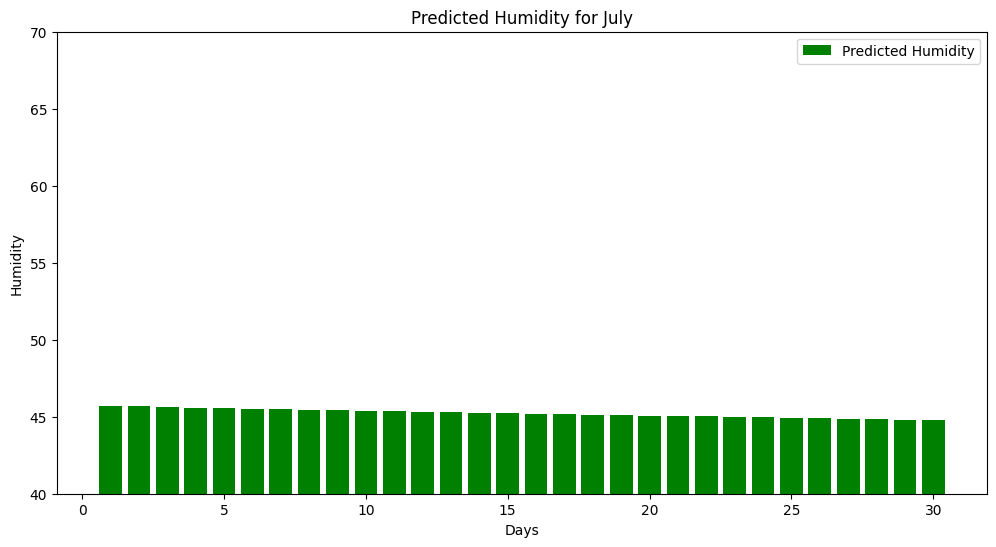

In [16]:
for i, month_predictions in enumerate(future_predictions):
    days = np.arange(1, 31)

    plt.figure(figsize=(12, 6))
    plt.bar(days, month_predictions[:, 0], color='blue', label='Predicted CO2')
    plt.ylim(500, 900)
    plt.title(f'Predicted CO2 for {month_names[i]}')
    plt.xlabel('Days')
    plt.ylabel('CO2')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(days, month_predictions[:, 1], color='red', label='Predicted Temperature')
    plt.ylim(20, 27)
    plt.title(f'Predicted Temperature for {month_names[i]}')
    plt.xlabel('Days')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(days, month_predictions[:, 2], color='green', label='Predicted Humidity')
    plt.ylim(40, 70)
    plt.title(f'Predicted Humidity for {month_names[i]}')
    plt.xlabel('Days')
    plt.ylabel('Humidity')
    plt.legend()
    plt.show()

sjdkhbkwb

In [ ]:
# Function to preprocess data for a new location
def preprocess_data_for_location(df, location, look_back=10):
    df_location = df[df['location'] == location].pivot_table(index='_time', columns='_field', values='_value').reset_index()
    df_location = df_location.fillna(method='ffill').fillna(method='bfill')
    scaled_data = scaler.transform(df_location[['co2', 'temperature', 'humidity']])

    X, Y = create_dataset(scaled_data, look_back)
    X = np.reshape(X, (X.shape[0], look_back, X.shape[2]))

    return X, Y, scaled_data

# Predict for another location
new_location = 'eui-24e124128c147500'
X_new, Y_new, scaled_data_new = preprocess_data_for_location(df, new_location)

In [ ]:
# Make new predictions
future_steps = 30  # Example: Predict next 30 days
last_values_new = scaled_data_new[-look_back:]
input_data_new = np.reshape(last_values_new, (1, look_back, 3))

predictions_new = []
for _ in range(future_steps):
    next_pred_new = model.predict(input_data_new)
    predictions_new.append(next_pred_new[0])
    input_data_new = np.append(input_data_new[:, 1:, :], [next_pred_new], axis=1)

# Inverse transform predictions
predictions_new = scaler.inverse_transform(predictions_new)
pred_mean_new = np.mean(predictions_new, axis=0)

print(f"Predicted mean values for February next year in room {new_location}:")
print(f"CO2: {pred_mean_new[0]:.2f}, Temperature: {pred_mean_new[1]:.2f}, Humidity: {pred_mean_new[2]:.2f}")

1/1 [==============================] - 0s 26ms/step
Predicted mean values for February next year in room eui-24e124128c147500:
CO2: 634.07, Temperature: 22.91, Humidity: 53.25


3079/3079 [==============================] - 24s 8ms/step


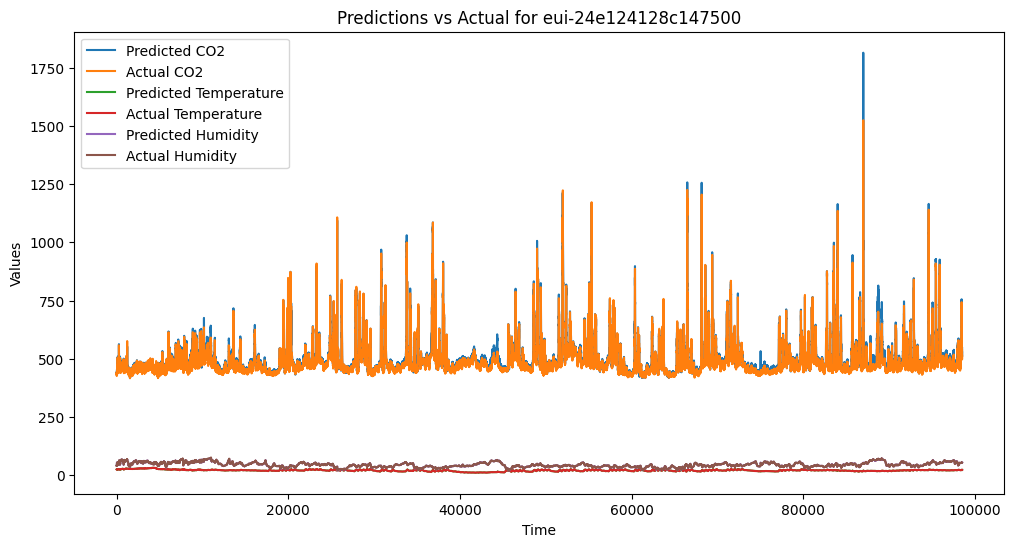

In [ ]:
from matplotlib import pyplot as plt

# Make new predictions
Y_new_pred = model.predict(X_new)
Y_new_pred_inv = scaler.inverse_transform(Y_new_pred)
Y_new_inv = scaler.inverse_transform(Y_new)

# Plot predictions vs actual values for a new location
def plot_predictions(predictions, actual, title):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[:, 0], label='Predicted CO2')
    plt.plot(actual[:, 0], label='Actual CO2')
    plt.plot(predictions[:, 1], label='Predicted Temperature')
    plt.plot(actual[:, 1], label='Actual Temperature')
    plt.plot(predictions[:, 2], label='Predicted Humidity')
    plt.plot(actual[:, 2], label='Actual Humidity')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

# Plot the predictions for the new location
plot_predictions(Y_new_pred_inv, Y_new_inv, f'Predictions vs Actual for {new_location}')


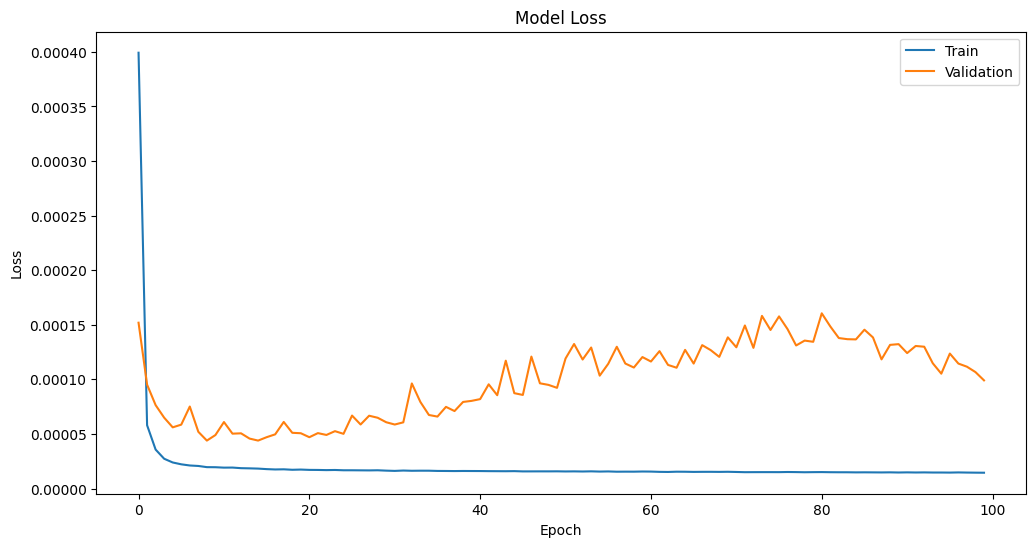

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()